# Coronavirus Sequence Analysis 

The goal of this activity is to get experience applying the tools learned over the last three days to a biological example.

This project has been adapted from an assignment given in Computational Genomics (MSCBIO 02-710) at Carnegie Mellon Spring 2020.

As we are all aware a new type of coronavirus 2019-nCoV was found in patients during an outbreak of respiratory illnesses in Wuhan, China starting near the end of 2019. This project is going to examine some of the first 2019-nCoV genome sequences that were detected and recorded from different countries and regions. 

You will be using 4 files:
* `Coronaviridae_2019.fasta` - 158 genome sequences of 2019-nCoV 
* `Coronaviridae_2019_information_table.txt` - the information about these 158 sequences. It contains 3 columns, the first column represents accession IDs, the second column represents specific names of viruses, and the third column represents locations the viruses been detected 
* `Coronaviridae_old_information_table.txt` - 208 genome sequences of different types of coronavirus reported earlier.
* `Coronaviridae_old_information_table.txt` - the information of these 208 sequences. It containes 4 columns, the first column represents accession IDs, the second column represents specific names of viruses, the third column represents host-names of viruses, and the last column contains the information of virus lineage

These datasets were downloaded from [GISAID](https://www.gisaid.org/) and [Virus-Host DB](https://www.genome.jp/virushostdb/)  

Let's look at the data before going further. We will be using `SeqIO` the standard sequence input/output interface for BioPython. We need to load the sequences and their corresponding `.txt` files. Luckily, there is a straightforward method to do this.

In [1]:
#import relavent modules including the piece of Biopython we need 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO

In [2]:
record_dict_old = SeqIO.to_dict(SeqIO.parse('data/Coronaviridae_old.fasta', 'fasta'))
record_dict_old_index = SeqIO.index('data/Coronaviridae_old.fasta','fasta')

By looking at one of the sequences we can see what sort of information is contained within the `.fasta` file. It is a little hard to read but there is a sequence, ID, and several descriptors. The other version with the function `SeqIO.index` is used to put the sequences in a format that will be useful later.

In [3]:
record_dict_old['AC_000192']

SeqRecord(seq=Seq('tataagagtgattggcgtccgtacgtaccctctctactctaaaactcttgtagt...aaa', SingleLetterAlphabet()), id='AC_000192', name='AC_000192', description='AC_000192 Murine hepatitis virus strain JHM|Mus musculus|Viruses; Riboviria; Nidovirales; Cornidovirineae; Coronaviridae; Orthocoronavirinae; Betacoronavirus; Embecovirus; Murine coronavirus; Murine hepatitis virus|Eukaryota; Metazoa; Chordata; Craniata; Sarcopterygii; Mammalia; Euarchontoglires; Rodentia; Myomorpha; Muridae; Murinae; Mus; Mus||', dbxrefs=[])

We can also use the `help()` function in python to figure out what was done above to read in the files. We first used `SeqIO.parse` 

In [4]:
help(SeqIO.parse)

Help on function parse in module Bio.SeqIO:

parse(handle, format, alphabet=None)
    Turn a sequence file into an iterator returning SeqRecords.
    
    Arguments:
     - handle   - handle to the file, or the filename as a string
       (note older versions of Biopython only took a handle).
     - format   - lower case string describing the file format.
     - alphabet - optional Alphabet object, useful when the sequence type
       cannot be automatically inferred from the file itself
       (e.g. format="fasta" or "tab")
    
    Typical usage, opening a file to read in, and looping over the record(s):
    
    >>> from Bio import SeqIO
    >>> filename = "Fasta/sweetpea.nu"
    >>> for record in SeqIO.parse(filename, "fasta"):
    ...    print("ID %s" % record.id)
    ...    print("Sequence length %i" % len(record))
    ...    print("Sequence alphabet %s" % record.seq.alphabet)
    ID gi|3176602|gb|U78617.1|LOU78617
    Sequence length 309
    Sequence alphabet SingleLetterAlphabe

As the documentation mentions we use this to open a file to read in a loop over the records. The second function `SeqIO.to_dict` as you can probably guess takes this information and putts it in a dictionary for later use. **Please read in the 2019 data in a similar manor bellow and save it to a dictionary**

In [5]:
## read in 2019-nCoV sequences (delete the stuff below this)

record_dict_new = SeqIO.to_dict(SeqIO.parse('data/Coronaviridae_2019_new.fasta','fasta'))
record_dict_new_index = SeqIO.index('data/Coronaviridae_2019_new.fasta','fasta')

## Part 1: Virus clustering 
**Your goal**  is to cluster viral sequences from the two fasta files according to their sequence information to see how different the new Coronavirus sequences are from the old ones. We are going to break this process into several steps that make it easier to follow. 

### Step 1: Calculate the frequency of each *k*-mer in each sequence.

We are using *k*-mers because it makes the data have a more manigable number of dimensions that we can work with. For example, if you have a sequence "AAAG" and set k=2 then the frequency of "AA" is 2, "AG" is 1, and all other 2-mers are 0. We are going to get these frequencies for all of the sequences in our datasets.

There are several possible approaches to what we want to do (see if you can think of another one), you are going to determine all the possible *k*-mers for normal nucleic acid sequences and then search each sequence for that information. This approach assumes a few things (can you think of one? **include assumption here**)

In [6]:
import itertools
import re

In [7]:
# function to get k-mers
def get_kmers(k):
    tupls = itertools.product('AGCT',repeat=k) #this function creates iterable objects from the string that you give it
    kmers = []
    for tup in tupls:
        string =  ''.join(tup) 
        kmers.append(string) # this is adding each kmer to a list called kmer for later use 
    return kmers

Do you know what `string = ''.join(tup)` line is doing? Can you add a print statement to figure it out? **include explination of that line here**

Run the function for some number k (between 2 and 6) and save the list of kmers as a variable for later use:

In [13]:
## run the function and save the output to a variable called kmers (delete the stuff below this comment)
kmers = get_kmers(3)

In [15]:
len(kmers)

64

Now that we have a list of possible *k*-mers we need to search all the sequences in our dataset for these *k*-mers and save them into vectors for future use. We have taken sequences and transformed them into a data format (vectors) which is much easier to use for furture analysis. What we are going to end up with is a vector for each sequence and each number within that vector corresponds to the number of times that *k*-mer is found within that sequence.

In [12]:
record_dict_new_index = SeqIO.index('data/Coronaviridae_2019_new_aligned.fasta','fasta')
record_dict_old_index = SeqIO.index('data/Coronaviridae_old.fasta','fasta')

In [16]:
## this function is missing two lines. 
## 1.the first line and it initializes a numpy array (of zeros) that is 
## the length of the list of kmers you just generated
## 2. Adds the vector with frequenceis (vect) to the vector in 1 via a vertical stack 

def make_vectors(dic, kmers):
    k_mers_vects = np.zeros((len(kmers))) # remove this line 
    for seq in dic:
        seq_i = dic.get_raw(str(seq)).decode().upper() # we need .upper because this method assumed that all the nucleiotides would be upper case letters 
        vect = []
        for mer in kmers:
            vect.append(len(re.findall(mer,seq_i)))# this line finds all the instances of a particular mer in the sequence
        k_mers_vects = np.vstack((k_mers_vects, vect)) #remove this line 
    final = np.delete(k_mers_vects,0,axis=0)
    return (final.T/final.sum(axis=1)).T

Run this function on the new and old datasets saving the output to variables. 

In [17]:
## Run the above function and save the output using your generated kmers and the format of the data called _index 

new_vects = make_vectors(record_dict_new_index, kmers)
old_vects = make_vectors(record_dict_old_index,kmers)

### Step 2: Prefrom dimensionality reduction using PCA

PCA stands for Principal Component Analysis:

>**What Is Principal Component Analysis?**
Principal Component Analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.
Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process.
So to sum up, the idea of PCA is simple — reduce the number of variables of a data set, while preserving as much information as possible. More information can be found [here](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)

We are going to use this method to reduce our data from having the same number of features/demensions as the number of possible *k*-mers to just 2 dimensions, which will make it easier to use.

Just like the other examples we have seen using `scikit-learn` setting this up actually only takes a couple lines of code after we have imported all the required modules.

In [18]:
from sklearn.decomposition import PCA

Bellow is the skelaton of a function that initiates a PCA element and then fits and transforms the data we give it (the vectors of k-mers) returning the demension reduced data. I have placed this in a function so it is easier to use multiple times.

It is missing one thing. When the PCA is being initiated you have to give it the number of components/demensions that you want as output. **You need to determine this number and add the correct parameter**. Then you need to combine the two sets of vectors (new and old) into one large matrix with all the sequences and run PCA on that final matrix. 

In [19]:
help(PCA)

Help on class PCA in module sklearn.decomposition._pca:

class PCA(sklearn.decomposition._base._BasePCA)
 |  PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
 |  
 |  Principal component analysis (PCA).
 |  
 |  Linear dimensionality reduction using Singular Value Decomposition of the
 |  data to project it to a lower dimensional space. The input data is centered
 |  but not scaled for each feature before applying the SVD.
 |  
 |  It uses the LAPACK implementation of the full SVD or a randomized truncated
 |  SVD by the method of Halko et al. 2009, depending on the shape of the input
 |  data and the number of components to extract.
 |  
 |  It can also use the scipy.sparse.linalg ARPACK implementation of the
 |  truncated SVD.
 |  
 |  Notice that this class does not support sparse input. See
 |  :class:`TruncatedSVD` for an alternative with sparse data.
 |  
 |  Read more in the :ref:`User Guide <PCA>`.
 |  
 |  Pa

In [20]:
def pca(vects, components):
    pca = PCA(n_components=components) ## remove the inside of this function
    return pca.fit_transform(vects)

In [21]:
## (1) Combine the two data sets with the sequences from 2019-nCoV in the front
## (2) run the function for your two sets of data using the correct number of components and save the output to a variable

final_vects = np.vstack((new_vects,old_vects))

pca_final = pca(final_vects,2)


### Step 3: Perform K-means on the reduced dataset

We covered K-means briefly earlier; if you are curious for more information [this blog post](https://365datascience.com/k-means-clustering/) has a good explination.

Similarly to PCA, once we have input the required modules it is very eary to run this analysis. We will then plot the results to see if this method captures the difference between the new and old sequences.

In [22]:
from sklearn.cluster import KMeans

In [27]:
# try a couple different values for the n_clusters to see what sort of representations you get 
# (remove n_clusters =)

kmeans = KMeans(n_clusters=5).fit_predict(pca_final)

Finally we will plot our results: 

What we are actually plotting is the two principle components becuase that gives us two dimensions which is much easier to see. We will color the scatter plot based on labels from K-means and then indicate the 2019-nCoV sequences using a red dot in the center.


Text(0, 0.5, 'PC2')

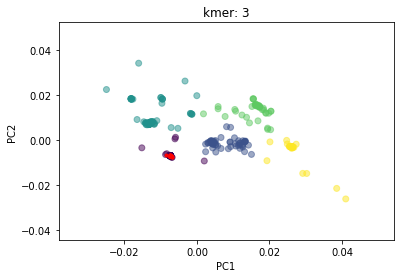

In [29]:
plt.scatter(pca_final[:,0],pca_final[:,1],alpha =0.5, c=kmeans)
plt.scatter(pca_final[0:150,0],pca_final[0:150,1], marker = '.', c='red')
plt.title('kmer: 3')
plt.xlabel('PC1')
plt.ylabel('PC2')

### Conclusions:

* Was your demension reduced data able to seperate the new sequences from the old ones? 
* If not what could you change to see if they do?
* What sort of sequences ended up in the same cluster as the new ones? 

## Part 2: Phylogenetic analysis

In this part our goal is to analyze relationsips of new coronaviruses reported from different countries or regions. You will only need the `new` data for this part of the project. This part has been adapted from [this](https://towardsdatascience.com/molecular-phylogenetics-using-bio-phylo-57ce27492ee9) article which has a more complete explination of this process.

For this analysis we need to used aligned sequences and since we have a lot of sequences what we want is a multiple sequence alignment (MSA). You can learn more about what that exactly does [here](https://en.wikipedia.org/wiki/Multiple_sequence_alignment). In the interest of time we have provided you with pre-aligned files so you actually don't have to do that, but if you are interested [this](https://www.ebi.ac.uk/Tools/msa/clustalo/) is one web-server that does it. 

### Some background 

>**phylogenetics** is the study of the evolutionary history and relationships amoung individuals or groups of orangisms (according to Wikipedia

>**Phylogenetic Trees** represent evolutionary replationships between organisms. The pattern of branching in a phylogenetic tree reflects how species or other groups have evolved from a series of common ancestors. 

The image below is s simple example of what we will create with the 2019-nCoV sequences 

![image](https://miro.medium.com/max/2656/1*K5E_zuQyleVYGHmulioAWQ.png)

Source from [medium article](https://towardsdatascience.com/molecular-phylogenetics-using-bio-phylo-57ce27492ee9) 

In [30]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import AlignIO

### Step1: Determine the distance between different sequences

The `DistanceTreeConstructor` supports the use of two algorithms for determining distance between sequences we will be using `Unweighted Pair Group Method with Arithmetic Mean` you can read more about it and the other options in the documentation. 



In [31]:
aln = AlignIO.read('data/Coronaviridae_2019_new_aligned.fasta','fasta')

Similar to the other methods we have used today to determine the distances we have to initilize ths distance constructor and then use it to determine the distances we are interested in

In [32]:
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(aln)

KeyboardInterrupt: 

Then we use a very similar method to initilize and then construct the tree using `upgma`

In [ ]:
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

Finally we will plot the resluts of the full tree. There are 150 sequences in this data set so the above cells may take some time to run. The resulting plot is also very difficult to view so below we will see some ways we can make this more interpretable.

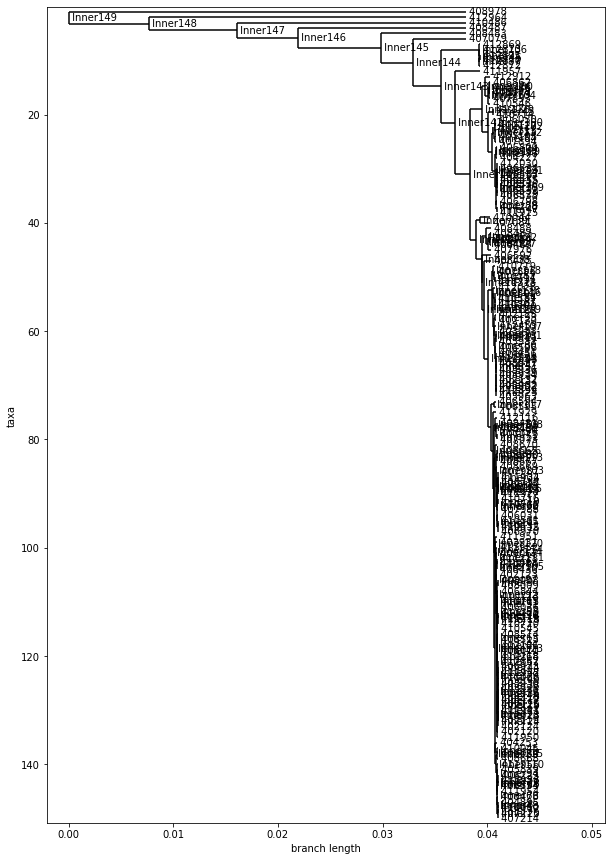

In [ ]:
fig = plt.figure(figsize=(10,15))
axes = fig.add_subplot(1,1,1)
Phylo.draw(tree, axes=axes,do_show=False)

Lets try making this again with every 10th sequence so we have 15 instead of 150:
How can you index the aln object to get every 10th element?

*Hint* try messing around with the aln object outside of this cell to see what it looks and how you can index it (you can add a cell by pressing esc A (above) or esc B (below))


In [37]:
help(DistanceCalculator)

Help on class DistanceCalculator in module Bio.Phylo.TreeConstruction:

class DistanceCalculator(builtins.object)
 |  DistanceCalculator(model='identity', skip_letters=None)
 |  
 |  Class to calculate the distance matrix from a DNA or Protein.
 |  
 |  Multiple Sequence Alignment(MSA) and the given name of the
 |  substitution model.
 |  
 |  Currently only scoring matrices are used.
 |  
 |  :Parameters:
 |      model : str
 |          Name of the model matrix to be used to calculate distance.
 |          The attribute ``dna_matrices`` contains the available model
 |          names for DNA sequences and ``protein_matrices`` for protein
 |          sequences.
 |  
 |  Examples
 |  --------
 |  Loading a small PHYLIP alignment from which to compute distances::
 |  
 |      from Bio.Phylo.TreeConstruction import DistanceCalculator
 |      from Bio import AlignIO
 |      aln = AlignIO.read(open('TreeConstruction/msa.phy'), 'phylip')
 |      print(aln)
 |  
 |  Output::
 |  
 |      Singl

In [33]:
calculator2 = DistanceCalculator('identity')
dm2 = calculator2.get_distance(aln[0:150:10]) ## remove the indexer 

In [34]:
constructor = DistanceTreeConstructor()
tree2 = constructor.upgma(dm2)

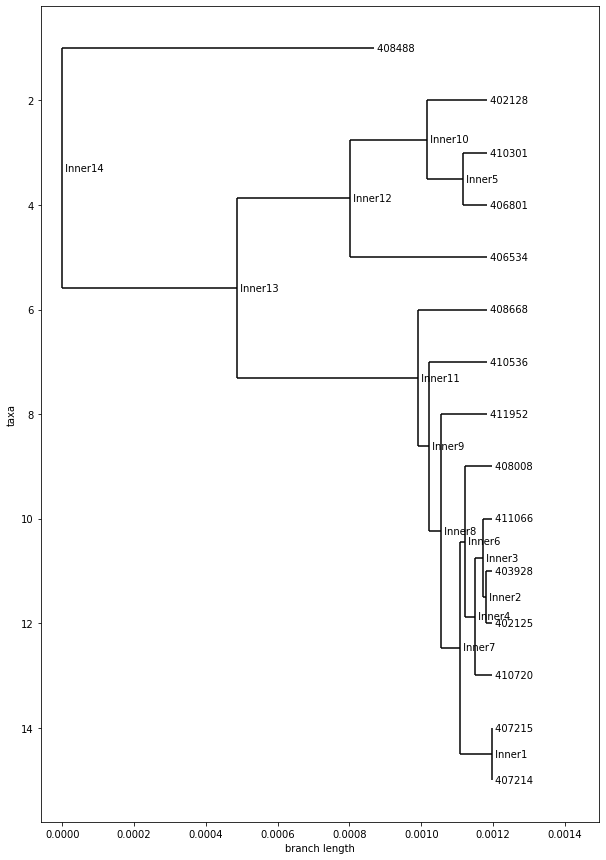

In [35]:
fig = plt.figure(figsize=(10,15))
axes = fig.add_subplot(1,1,1)
Phylo.draw(tree2, axes=axes,do_show=False)

This is more readble, but is still just full of numbers and we are interested in the descriptions of the numbers. 

`SeqIO` objects have an attribute called description built in so we are going to print out those and look at them. This is some of the words that were after the sequence in the dictionary we looked at in the beginning. You will need to use the same indexing as was used above in the `for` loop below.

In [36]:
# remove []
for i in aln[0:150:10]:
    print(i.description)

407214 BetaCoV/USA/WA1-A12/2020|EPI_ISL_407214
411952 BetaCoV/Jiangsu/JS02/2020|EPI_ISL_411952
408668 BetaCoV/Vietnam/VR03-38142/2020|EPI_ISL_408668
410720 BetaCoV/France/IDF0372-isl/2020|EPI_ISL_410720
407215 BetaCoV/USA/WA1-F6/2020|EPI_ISL_407215
408488 BetaCoV/Jiangsu/IVDC-JS-001/2020|EPI_ISL_408488
402125 BetaCoV/Wuhan-Hu-1/2019|EPI_ISL_402125
410536 BetaCoV/Singapore/5/2020|EPI_ISL_410536
411066 BetaCoV/Fujian/13/2020|EPI_ISL_411066
406534 BetaCoV/Foshan/20SF207/2020|EPI_ISL_406534
406801 BetaCov/Wuhan/WH04/2020|EPI_ISL_406801
408008 BetaCoV/USA/CA3/2020|EPI_ISL_408008
402128 BetaCoV/Wuhan/WIV05/2019|EPI_ISL_402128
410301 BetaCoV/Nepal/61/2020|EPI_ISL_410301
403928 BetaCoV/Wuhan/IPBCAMS-WH-05/2020|EPI_ISL_403928


## Conclusions:
* Do the sequences that are the closest together make sense to you?
* you can try a different indexing to see other pieces of the file
* What sort of information could you gain from looking at these trees?